## **This script will evaluate the membrane passive propertieis of CRH cells in the BNST between a Sapap3 KO mouse line and a WT line**
*Written by Omer Richmond* 
*Yizhar Lab*
*Weizmann institute* 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyabf
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.cm as cm
from functions_for_uri import *

# Set Calibri font for all plots
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = ['Calibri', 'Arial', 'DejaVu Sans', 'Liberation Sans']

### *Example of an IV curve*

C:\Users\omerich.WISMAIN\AppData\Local\Temp\ipykernel_724\1966796777.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


Text(0.5, 0, 'Time (s)')

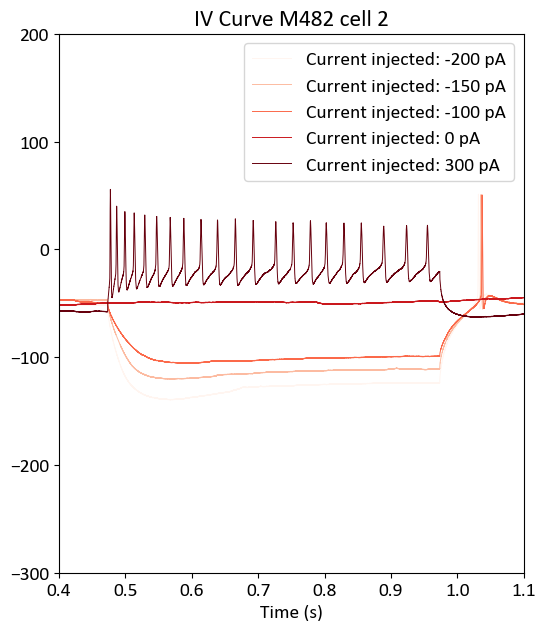

In [ ]:
iv_path = r"""Z:\Omer\Ph.D\Project- Uri's sapap3ko_vs_wt_crh_cells\Data\14.07.25\2025_07_14_0006.abf"""
abf = pyabf.ABF(iv_path)
colormap = 'Reds'  
cmap = cm.get_cmap(colormap)
sweeps_to_plot =[0,1,2,4,10] # I'm choosing those specific sweeps to plot
plt.figure(figsize=(6, 7))

for idx, sweep in enumerate(sweeps_to_plot):
    abf.setSweep(sweep)
    plt.plot(abf.sweepX,abf.sweepY,label=f'Current injected: {(-200)+(sweep)*50} pA',color=cmap(idx / (len(sweeps_to_plot)-1)),linewidth=0.7)

plt.title("IV Curve M482 cell 2")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.legend()
plt.ylim(-300, 200)
plt.xlim(0.4, 1.1)

### Example of a Ramp protocol

C:\Users\omerich.WISMAIN\AppData\Local\Temp\ipykernel_724\3046669212.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


Text(0.5, 0, 'Time (s)')

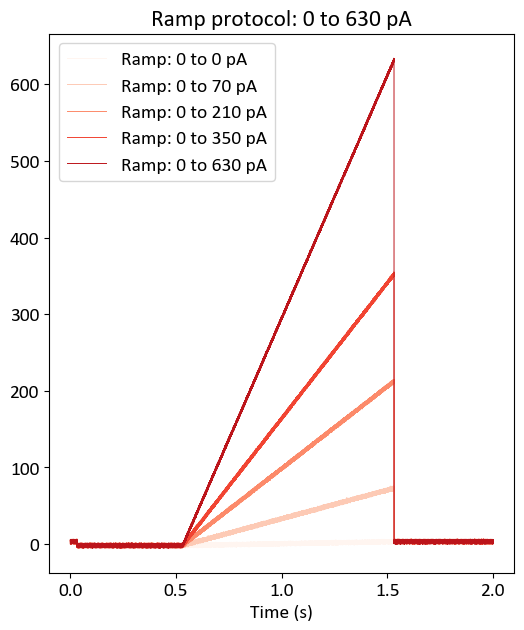

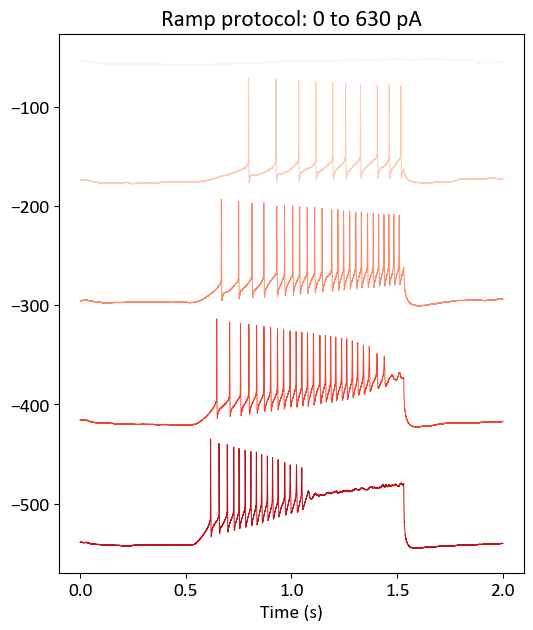

In [ ]:
ramp_path = r"""Z:\Omer\Ph.D\Project- Uri's sapap3ko_vs_wt_crh_cells\Data\14.07.25\2025_07_14_0007.abf"""
abf = pyabf.ABF(ramp_path)
cmap = cm.get_cmap(colormap)
plt.figure(figsize=(6, 7))
plt.title("Ramp protocol: 0 to 630 pA")
sweeps_to_plot =[0,1,3,5,9]
for idx, sweep in enumerate(sweeps_to_plot):
    abf.setSweep(sweep,2)
    plt.plot(abf.sweepX,abf.sweepY,label = f"Ramp: 0 to {(sweep*70)} pA",color=cmap(idx / (len(sweeps_to_plot))),linewidth=0.7)
plt.legend()
plt.xlabel("Time (s)")

plt.figure(figsize=(6, 7))
plt.title("Ramp protocol: 0 to 630 pA")
for idx, sweep in enumerate(sweeps_to_plot):
    abf.setSweep(sweep,1)
    plt.plot(abf.sweepX,abf.sweepY-(120*idx),color=cmap(idx / (len(sweeps_to_plot))),linewidth=0.7)
plt.xlabel("Time (s)")

### *Finding events in all sweeps of IV curve files*

In [ ]:
path = r"""Z:\Omer\Ph.D\Project- Uri's sapap3ko_vs_wt_crh_cells\Data\14.07.25"""

# Dictionary to store all tables with unique keys
all_sweep_tables = {}

for file in os.listdir(path):
    if file.endswith('.abf'):
        file_size = os.path.getsize(os.path.join(path, file)) / 1024  # Size in KB
        if file_size > 4110:
            continue  # Skip files smaller than 5000 KB
        file_name = file.replace('.abf', '')  # Remove .abf extension for cleaner names
        abf = pyabf.ABF(os.path.join(path, file))
        for sweep in abf.sweepList:
            abf.setSweep(sweep)
            cell_resting_potential = abf.sweepY[0:20000].mean()
            abf.setSweep(sweep,baseline=[0,20000])  # Calculate RMP from the first 20 ms
            table_key = f"{file_name}_sweep_{sweep}"
            try:
                cell_input_resistance = np.abs((np.mean(abf.sweepY[5000:20000]))-(np.mean(abf.sweepY[25000:45000])))/50 #50 pA per step  
                tbl = peaks_finder(-abf.sweepY, 30, 120, 10, 50000, plot_it=False, protocol="iv_curve")
                tbl['file_name'] = file_name
                tbl['sweep_number'] = sweep
                tbl['RMP (mV)'] = cell_resting_potential  # Calculate RMP from the first 20 ms
                tbl['Rm (GΩ)'] = cell_input_resistance
                tbl['table_key'] = table_key                    
                all_sweep_tables[table_key] = tbl
                print(f"  Sweep {sweep}: Found {len(tbl)} events - stored as '{table_key}'")

            except:
                print(f"  Sweep {sweep}: No events found or error processing - skipping '{table_key}'")
                cell_input_resistance = np.abs((np.mean(abf.sweepY[5000:20000]))-(np.mean(abf.sweepY[25000:45000])))/50 #50 pA per step
                tbl = pd.DataFrame(columns=['RMP (mV)', 'Rm (GΩ)'])  # Store empty DataFrame for failed processing
                tbl.loc[0, 'RMP (mV)'] = cell_resting_potential
                tbl.loc[0, 'Rm (GΩ)'] = cell_input_resistance
                all_sweep_tables[table_key] = tbl
print(f"\nTotal tables created: {len(all_sweep_tables)}")
print("Available table keys:", list(all_sweep_tables.keys()))               

  Sweep 0: No events found or error processing - skipping '2025_07_14_0000_sweep_0'
  Sweep 1: No events found or error processing - skipping '2025_07_14_0000_sweep_1'
  Sweep 2: No events found or error processing - skipping '2025_07_14_0000_sweep_2'
  Sweep 3: No events found or error processing - skipping '2025_07_14_0000_sweep_3'
  Sweep 4: No events found or error processing - skipping '2025_07_14_0000_sweep_4'
  Sweep 5: No events found or error processing - skipping '2025_07_14_0000_sweep_5'
  Sweep 6: No events found or error processing - skipping '2025_07_14_0000_sweep_6'
  Sweep 7: No events found or error processing - skipping '2025_07_14_0000_sweep_7'
  Sweep 8: No events found or error processing - skipping '2025_07_14_0000_sweep_8'
  Sweep 9: No events found or error processing - skipping '2025_07_14_0000_sweep_9'
  Sweep 10: No events found or error processing - skipping '2025_07_14_0000_sweep_10'
  Sweep 11: No events found or error processing - skipping '2025_07_14_000

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


c:\Users\omerich.WISMAIN\AppData\Local\anaconda3\envs\Uri's_project_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\omerich.WISMAIN\AppData\Local\anaconda3\envs\Uri's_project_venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\omerich.WISMAIN\AppData\Local\anaconda3\envs\Uri's_project_venv\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\omerich.WISMAIN\AppData\Local\anaconda3\envs\Uri's_project_venv\Lib\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\omerich.WISMAIN\AppData\Local\anaconda3\envs\Uri's_project_venv\Lib\site-packages\numpy\_core\_methods.py:2

Text(0.5, 1.0, 'IV curve responses')

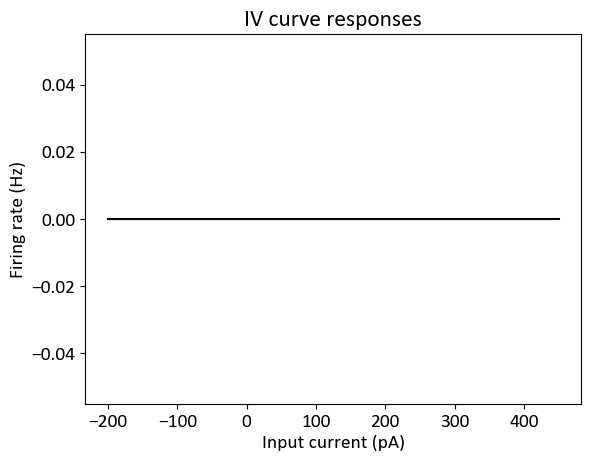

In [6]:
all_sweeps_average = []
all_sweeps_standard_deviation = []
resting_potential = []
resistance_input = []
for sweep in abf.sweepList:
    table_length = []
    current_sweep = f'_sweep_{sweep}'# Check if this is a sweep 0 table
    for key, table in all_sweep_tables.items():
        if key.endswith(current_sweep):
            table_length.append(len(table)-1)
            resting_potential.append(table['RMP (mV)'][0])
            resistance_input.append(table['Rm (GΩ)'][0])  # Store resting potential for each sweep
        mean_events = np.mean(table_length)
        std_events = np.std(table_length)/ np.sqrt(len(table_length))
    all_sweeps_average.append(mean_events)
    all_sweeps_standard_deviation.append(std_events)
all_sweeps_average = np.array(all_sweeps_average)
all_sweeps_standard_deviation = np.array(all_sweeps_standard_deviation)
print(all_sweeps_average)
print(all_sweeps_standard_deviation)

injection_current_steps = np.arange(-200, 500, 50)
plt.figure()
plt.plot(injection_current_steps,all_sweeps_average,color = 'k')
plt.fill_between(injection_current_steps, 
                  all_sweeps_average - all_sweeps_standard_deviation,
                  all_sweeps_average + all_sweeps_standard_deviation,
                  alpha=0.1, color='blue', label='±1 SD')
plt.ylabel("Firing rate (Hz)")
plt.xlabel("Input current (pA)")
plt.title("IV curve responses")  # Current steps from -200 to 200 pA

(-0.2, 5.0)

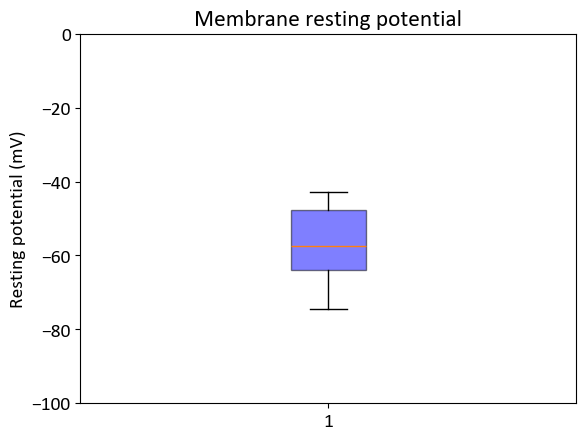

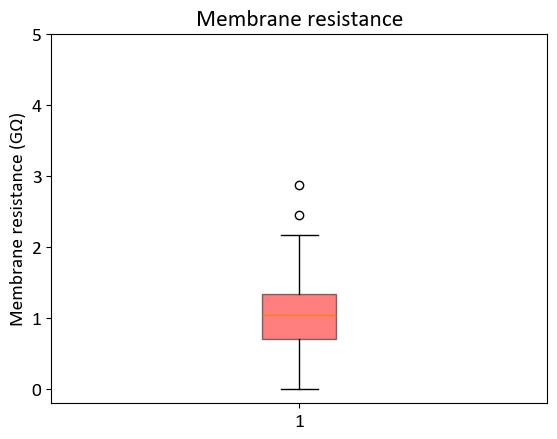

In [7]:
plt.figure()
plt.title("Membrane resting potential")
plt.boxplot(resting_potential, positions=[1], patch_artist=True,
            boxprops=dict(facecolor='blue', alpha=0.5))
plt.ylabel('Resting potential (mV)')
plt.ylim(-100, 0)

plt.figure()
plt.title("Membrane resistance")
plt.boxplot(resistance_input,positions = [1], patch_artist=True,
            boxprops=dict(facecolor='red', alpha=0.5))
plt.ylabel('Membrane resistance (GΩ)')
plt.ylim(-0.2,5)

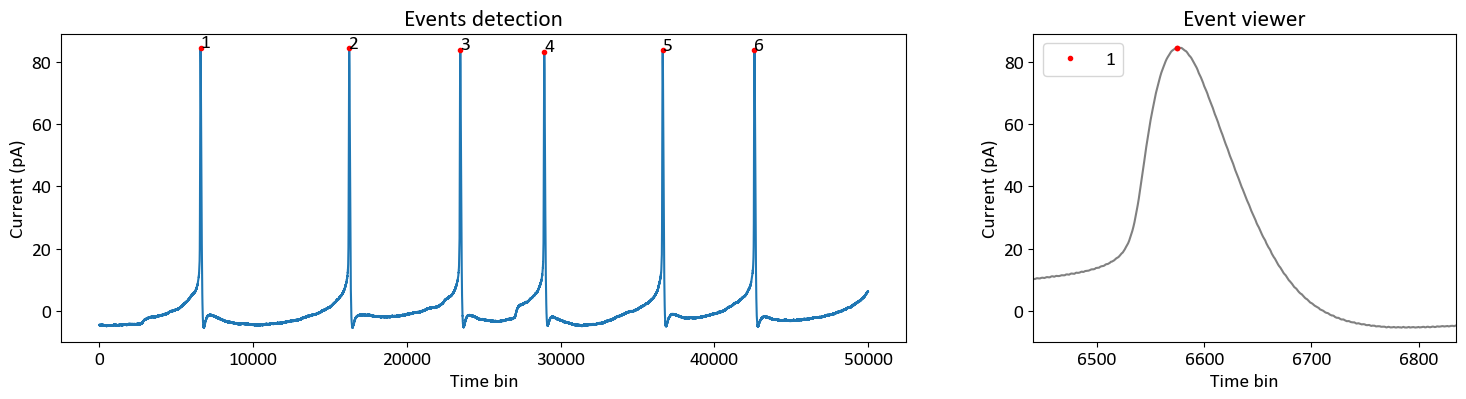

  Sweep 0: Found 6 events - stored as '2025_07_14_0001_sweep_0'
  Sweep 0: No events found or error processing - skipping '2025_07_14_0007_sweep_0'


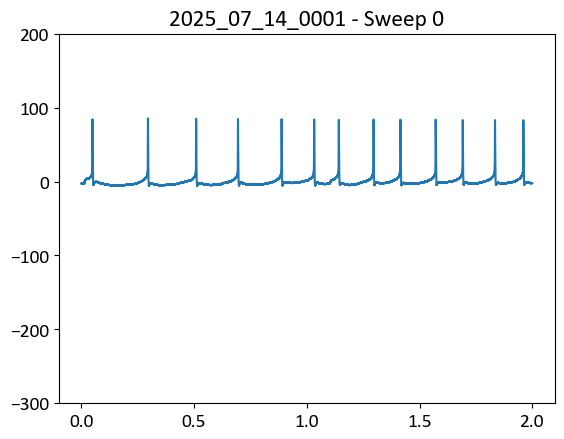

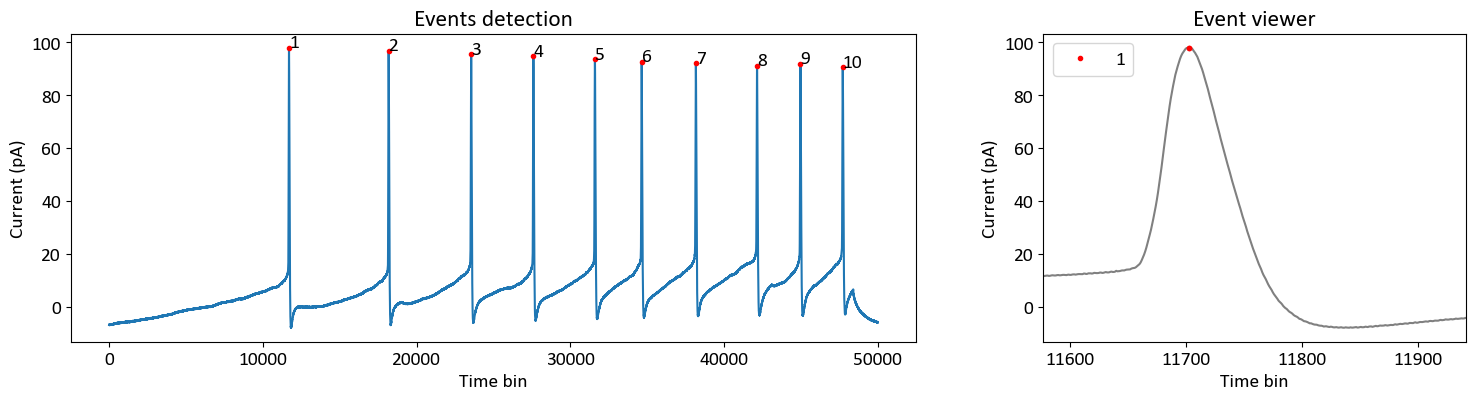

  Sweep 1: Found 10 events - stored as '2025_07_14_0007_sweep_1'
  Sweep 0: No events found or error processing - skipping '2025_07_14_0014_sweep_0'


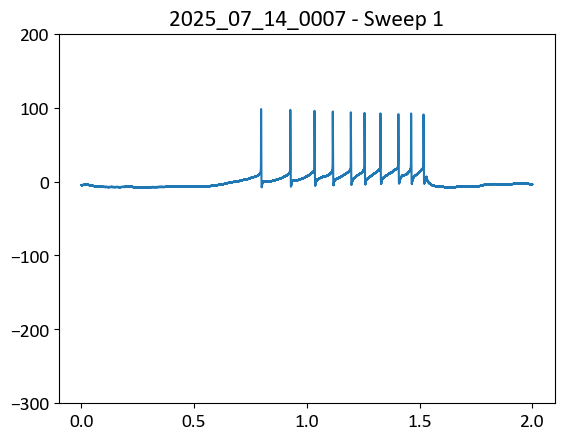

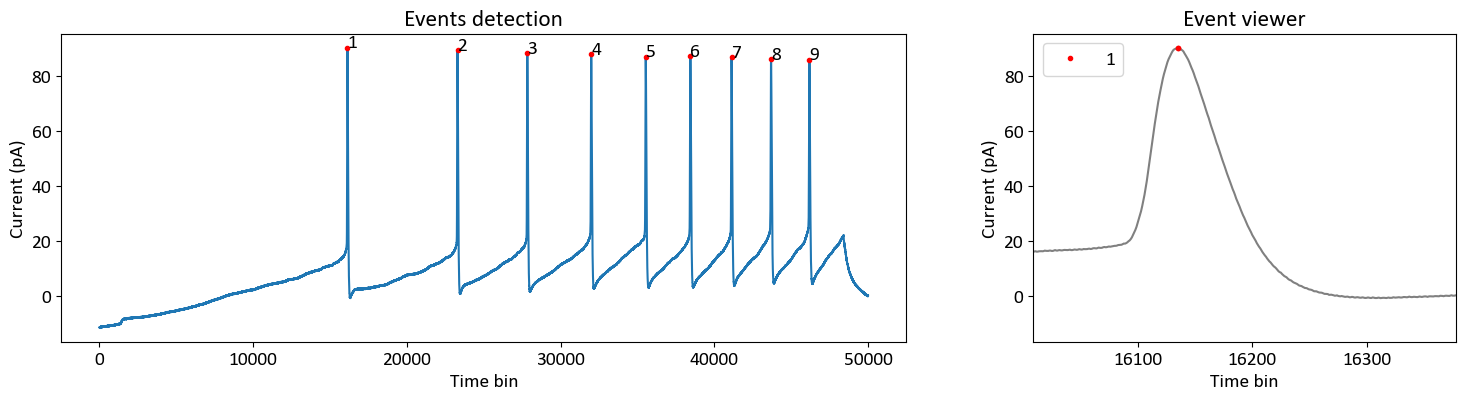

  Sweep 1: Found 9 events - stored as '2025_07_14_0014_sweep_1'


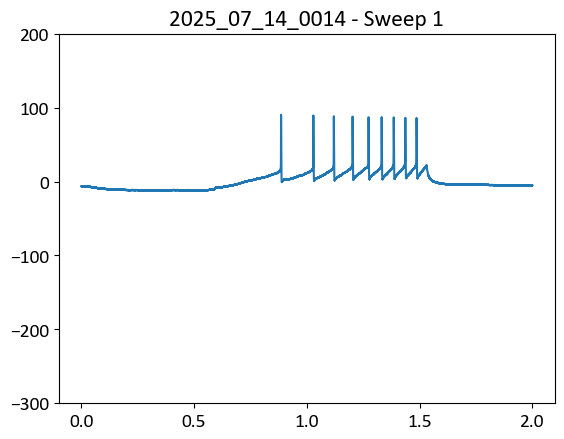

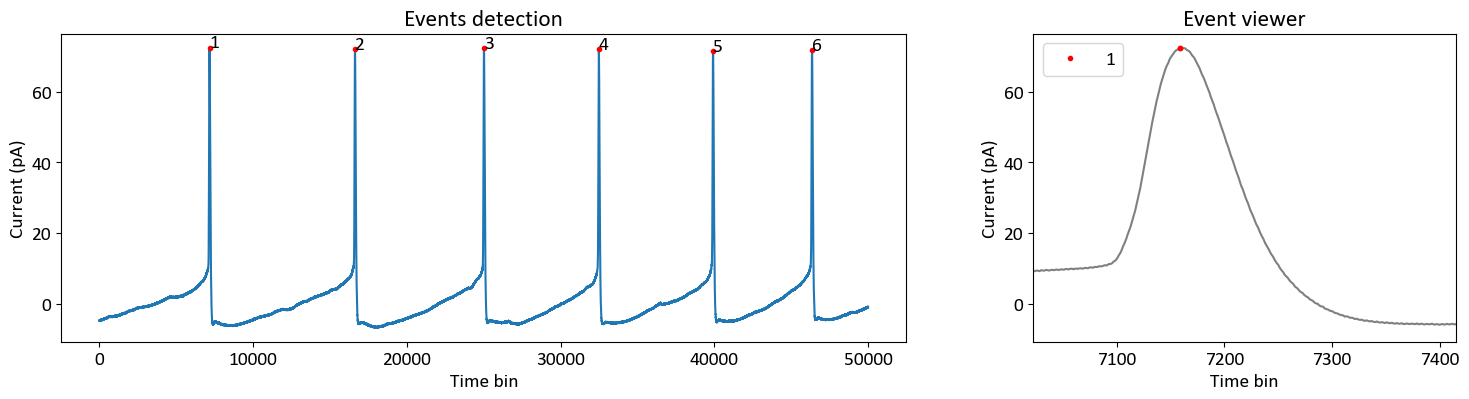

  Sweep 0: Found 6 events - stored as '2025_07_14_0034_sweep_0'

Total tables created: 4
Available table keys: ['2025_07_14_0001_sweep_0', '2025_07_14_0007_sweep_1', '2025_07_14_0014_sweep_1', '2025_07_14_0034_sweep_0']


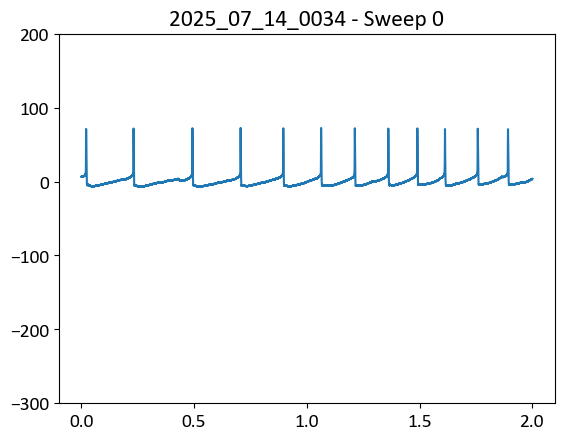

In [ ]:
path = r"""Z:\Omer\Ph.D\Project- Uri's sapap3ko_vs_wt_crh_cells\Data\14.07.25"""

# Dictionary to store all tables with unique keys
all_sweep_tables = {}

for file in os.listdir(path):
    if file.endswith('.abf'):
        file_size = os.path.getsize(os.path.join(path, file)) / 1024  # Size in KB
        if file_size < 5866 or file_size > 5868:
            continue  # Skip files smaller than 5000 KB
        file_name = file.replace('.abf', '')  # Remove .abf extension for cleaner names
        abf = pyabf.ABF(os.path.join(path, file))
        cell_number = 0
        for sweep in abf.sweepList:
            abf.setSweep(sweep,1,baseline=[0,20000])  
            table_key = f"{file_name}_sweep_{sweep}"

            try:
                tbl = peaks_finder(abf.sweepY, 30, 120, 10, 50000,"plot_it", "ramp_protocol")
                tbl['file_name'] = file_name
                tbl['sweep_number'] = sweep
                tbl['table_key'] = table_key
                tbl['cell_number']  = cell_number+1  # Increment cell number for each sweep                    
                plt.figure()
                plt.plot(abf.sweepX, abf.sweepY, label=f'Sweep {sweep}')
                plt.title(f"{file_name} - Sweep {sweep}")
                plt.ylim(-300, 200)
                all_sweep_tables[table_key] = tbl
                print(f"  Sweep {sweep}: Found {len(tbl)} events - stored as '{table_key}'")
                break

            except:
                print(f"  Sweep {sweep}: No events found or error processing - skipping '{table_key}'")
print(f"\nTotal tables created: {len(all_sweep_tables)}")
print("Available table keys:", list(all_sweep_tables.keys()))    